
Unvariate analysis of the data :)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yahoofinancials as yf
import requests
import ftplib
import io

In [26]:
history = yf.YahooFinancials('USDTRY=X').get_historical_price_data('2018-01-01', '2020-01-01', 'daily')

df = pd.DataFrame(history['USDTRY=X']['prices'])

df['date'] = pd.to_datetime(df['formatted_date'])
df['date'] = df['date'].dt.date
df = df.set_index('date')
df.head()

,high,low,open,close,volume,adjclose,formatted_date
date,,,,,,,
2018-01-01,3.79490,3.78900,3.79490,3.79490,0.0,3.79490,2018-01-01
2018-01-02,3.79130,3.75290,3.79130,3.79110,0.0,3.79110,2018-01-02
2018-01-03,3.77866,3.75550,3.76540,3.76560,0.0,3.76560,2018-01-03
2018-01-04,3.78480,3.74537,3.78080,3.78060,0.0,3.78060,2018-01-04
2018-01-05,3.75921,3.73050,3.74963,3.75027,0.0,3.75027,2018-01-05


In [27]:
df['returns'] = df['close'].diff()

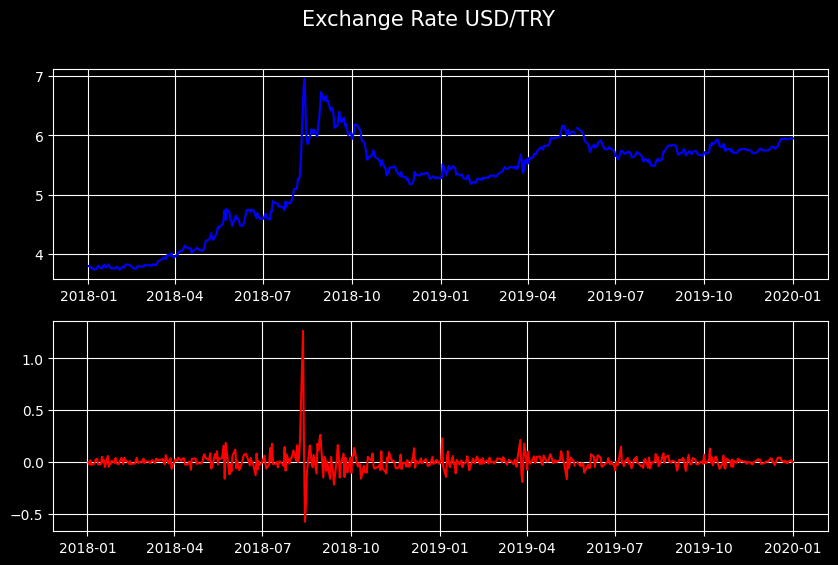

In [28]:
plt.style.use('dark_background')

a = plt.figure(figsize=(10, 6))
a.suptitle('Exchange Rate USD/TRY', fontsize=15)
plt.subplot(2, 1, 1)
plt.plot(df['close'], label='USD/TRY' , color = 'blue')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(df['returns'], label='Returns', color = 'red')
plt.grid(True)
plt.show() 

We can see from the plot that a stationary series by taking the difference but to be absolutely certain we can run a root test on our data.

In [29]:
print("Total positive returns: ", df[df['returns'] > 0]['returns'].shape[0])
print("Total negative returns: ", df[df['returns'] < 0]['returns'].shape[0])    

Total positive returns:  267
Total negative returns:  252


In [30]:
df['returns'].describe()

count    520.000000
mean       0.003956
std        0.086682
min       -0.578400
25%       -0.023268
50%        0.000675
75%        0.031300
max        1.265800
Name: returns, dtype: float64

Now we will perform some outlier detection and remove them if need be 

In [31]:
len(df)

523

[<Axes: >]

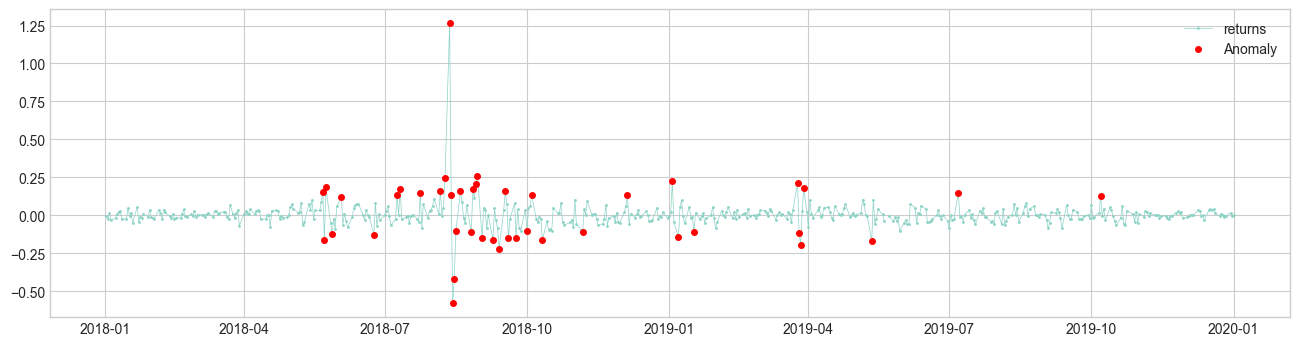

In [39]:
from adtk.detector import InterQuartileRangeAD
from adtk.visualization import plot

iqr = InterQuartileRangeAD(c=1.5)
anomalies = iqr.fit_detect(df['returns'])

plot(df['returns'], anomaly=anomalies, anomaly_color='red', anomaly_tag="marker")

In [40]:
not_anomalies = anomalies != 1
df = df[not_anomalies]
len(df)

481

Performing the Augmented Dickey-Fuller Test to check for stationary series

In [41]:
df.dropna(inplace=True)
len(df)

478

In [42]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['close'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

if adf_result[1] > 0.05:
    print('Time series is not stationary')
else:
    print('Time series is stationary')

ADF Statistic: -1.9380206188648301
p-value: 0.3143917246758491
Time series is not stationary


In [43]:
adf_result = adfuller(df['returns'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

if adf_result[1] > 0.05:
    print('Time series is not stationary')
else:    
    print('Time series is stationary')

ADF Statistic: -15.678152767611003
p-value: 1.4840417138422882e-28
Time series is stationary


Auto correlation and partial auto correlation on close

     ---------------------------------------- 0.0/15.4 MB ? eta -:--:--
     ---------------------------------------- 0.2/15.4 MB 5.3 MB/s eta 0:00:03
     -- ------------------------------------- 1.0/15.4 MB 10.6 MB/s eta 0:00:02
     ------ --------------------------------- 2.7/15.4 MB 19.0 MB/s eta 0:00:01
     ----------- ---------------------------- 4.4/15.4 MB 25.4 MB/s eta 0:00:01
     ---------------- ----------------------- 6.2/15.4 MB 28.6 MB/s eta 0:00:01
     --------------------- ------------------ 8.1/15.4 MB 30.6 MB/s eta 0:00:01
     ------------------------ --------------- 9.5/15.4 MB 30.4 MB/s eta 0:00:01
     ---------------------------- ---------- 11.2/15.4 MB 38.5 MB/s eta 0:00:01
     -------------------------------- ------ 13.0/15.4 MB 38.5 MB/s eta 0:00:01
     ------------------------------------- - 14.9/15.4 MB 38.5 MB/s eta 0:00:01
     --------------------------------------  15.4/15.4 MB 38.6 MB/s eta 0:00:01
     --------------------------------------- 15.4

  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [698 lines of output]
      Ignoring numpy: markers 'python_version == "3.5"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7"' don't match your environment
        Using cached setuptools-67.8.0-py3-none-any.whl (1.1 MB)
        Using cached wheel-0.40.0-py3-none-any.whl (64 kB)
           ---------------------------------------- 0.0/988.4 kB ? eta -:--:--
           ---------- --------------------------- 276.5/988.4 kB 8.6 MB/s eta 0:00:01
           ------------------------------------- 988.4/988.4 kB 12.5 MB/s eta 0:00:00
           ---------------------------------------- 0.0/6.4 MB ? eta -:--:--
           ---------- ----------------------------- 1.7/6.4 MB 36.8 MB/s eta 0:00:01
           ------------------- ----------------

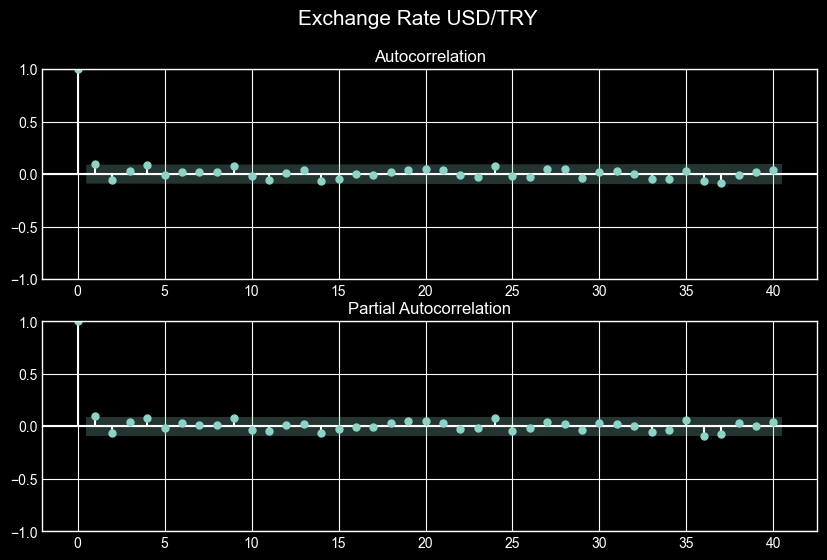

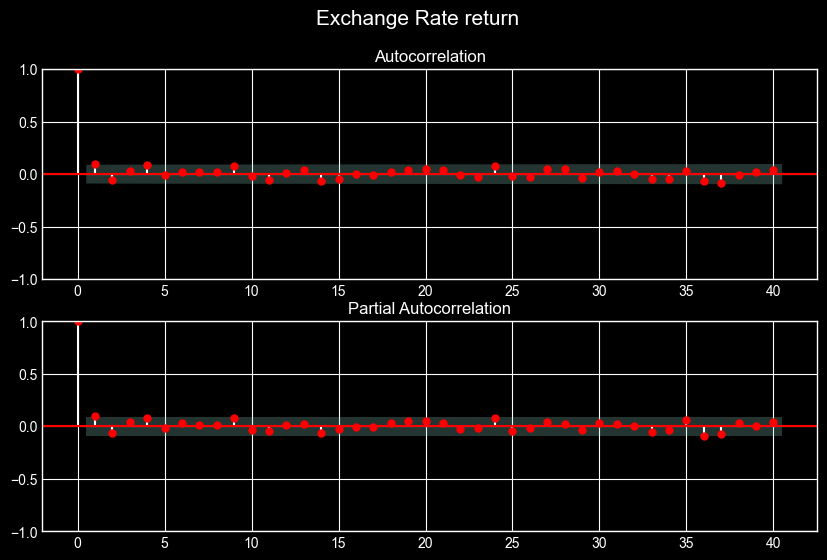

In [52]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('dark_background')

f =  plt.figure(figsize=(10, 6))
f.suptitle('Exchange Rate USD/TRY', fontsize=15)
ax1 = f.add_subplot(211)
fig = plot_acf(df['returns'], lags=40, ax=ax1)
ax2 = f.add_subplot(212)
fig = plot_pacf(df['returns'], lags=40, ax=ax2)

f = plt.figure(figsize=(10, 6))
f.suptitle('Exchange Rate return', fontsize=15)
ax1 = f.add_subplot(211)
fig =  plot_acf(df['returns'], lags=40, ax=ax1 , color = 'red')
ax2 =  f.add_subplot(212)
fig = plot_pacf(df['returns'], lags=40, ax=ax2 , color = 'red')

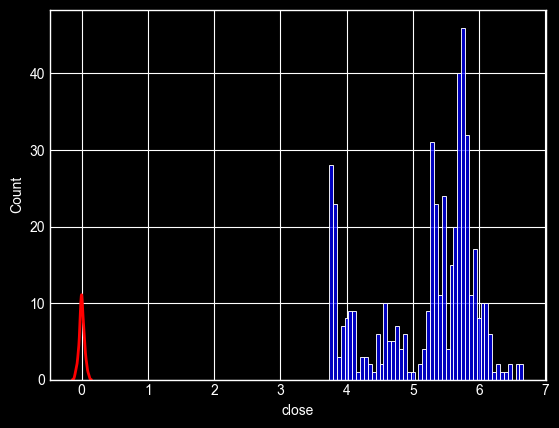

stat : 55.473, pvalue : 0.000
close series is not normal
stat : 0.509, pvalue : 0.775
returns series is normal


In [64]:
sns.histplot(df['close'], bins=50, color='blue', kde=False)

sns.kdeplot(df['returns'], color='red', linewidth=2)

plt.show()

from scipy.stats import jarque_bera

stat, pvalue = jarque_bera(df['close'])
print("stat : %.3f, pvalue : %.3f" % (stat, pvalue))

if pvalue > 0.05:
    print('close series is normal')
else:
    print('close series is not normal') 

stat, pvalue = jarque_bera(df['returns'])
print("stat : %.3f, pvalue : %.3f" % (stat, pvalue))

if pvalue > 0.05:
    print('returns series is normal')
else:  
    print('returns series is not normal')
    

<Axes: xlabel='close', ylabel='Count'>

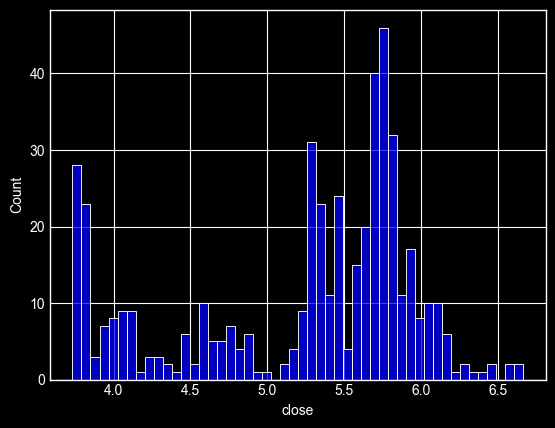

In [65]:
sns.histplot(df['close'], bins=50, color='blue', kde=False)

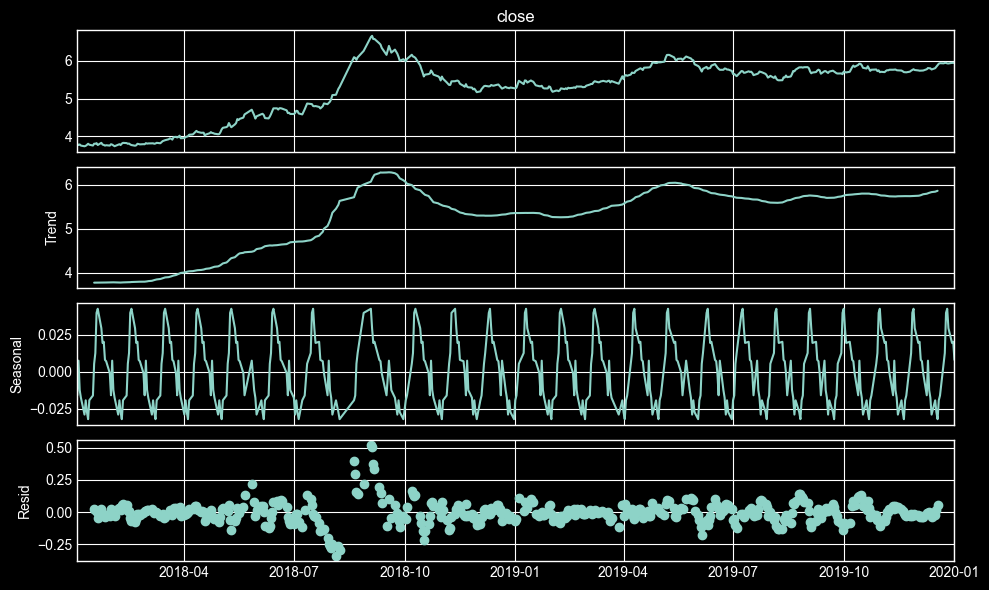

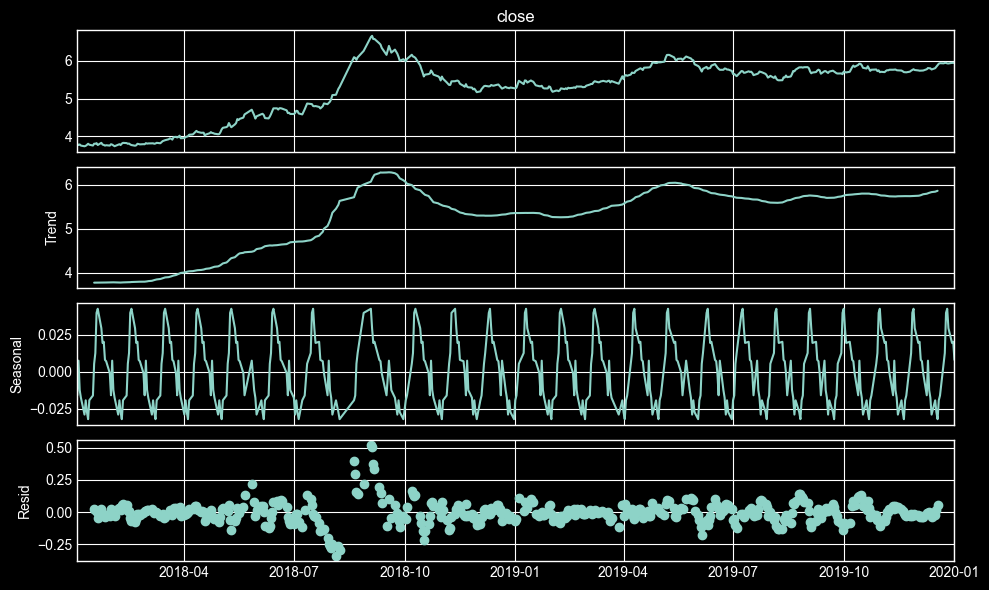

In [66]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from statsmodels.tsa.seasonal import seasonal_decompose

sd_result = seasonal_decompose(df['close'], model='additive', period = 20)
sd_result.plot()

We choose 20 days as period as we are considering 481 days worth of data spread over 2 years which is 24 months which comes out to be roughly 20.

The graphs with brief description:

First Graph gives us the time series itself which we are analysing.

Second Graph is the trend graph, which we observe has an upward trend, which is a hint that autoregressive process should be followed.

Third Graph shows the periodic change, It is clearly seen there is some is certain periodicity in the exchange rate.

Forth Graph contains residuals representing the error commponent sometimes also called the 'White Noise' , this pretty much tells us about the random and unpredictable
movements in the time series.


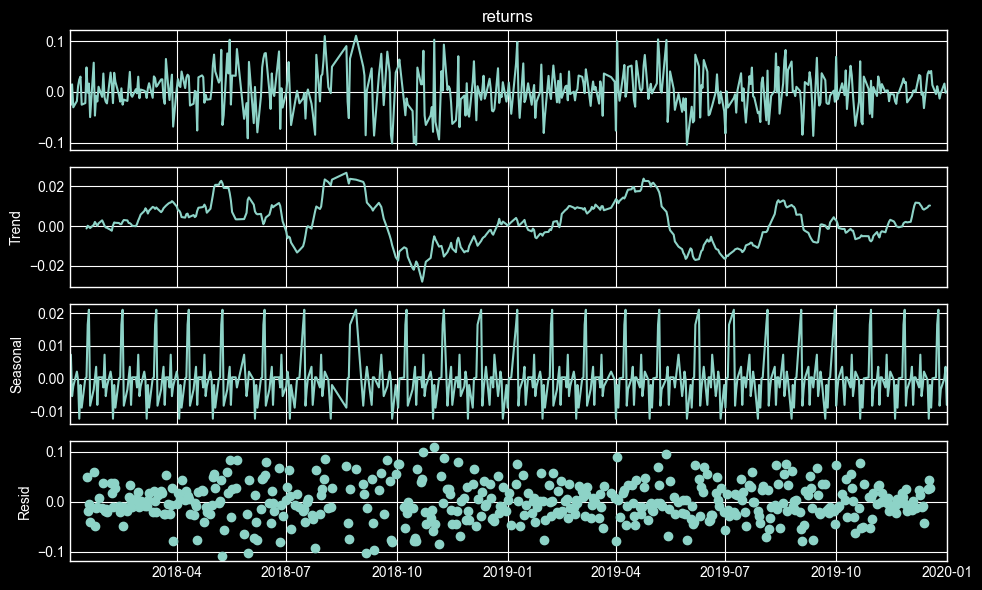

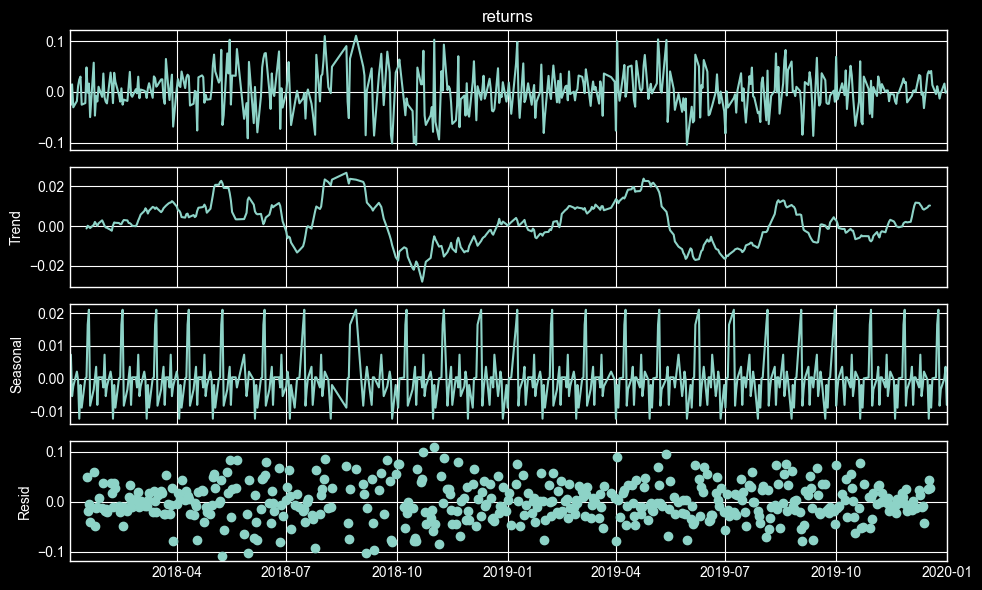

In [67]:
sd_result = seasonal_decompose(df['returns'], model='additive', period = 20)

sd_result.plot()

In [71]:
import pmdarima as pm

model = pm.auto_arima(df['close'], start_p=0, start_q=0,trace=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1269.428, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1269.390, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1269.136, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1269.030, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1272.891, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1267.994, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1268.247, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1269.743, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1269.852, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1273.763, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1268.987, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1269.294, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1268.143, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  478
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 639.881
Date:                Mon, 05 Jun 2023   AIC                          -1273.763
Time:                        22:15:29   BIC                          -1261.260
Sample:                             0   HQIC                         -1268.847
                                - 478                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8591      0.059     14.521      0.000       0.743       0.975
ma.L1         -0.7899      0.072    -10.949      0.000      -0.931      -0.648
sigma2         0.0040   6.91e-05     57.897      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):             43867.60
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             4.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

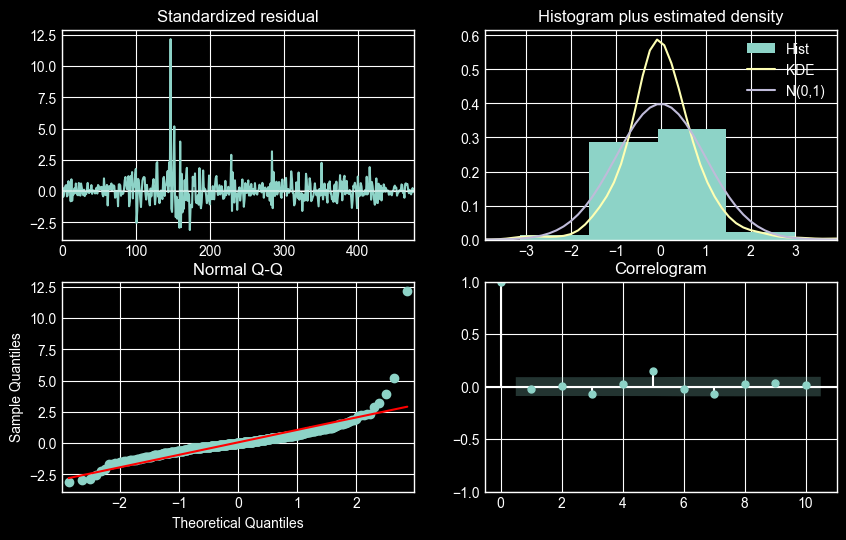

In [72]:
model.plot_diagnostics(figsize=(10, 6))
plt.show()

A brief summary on what the graph show us:
Pretty much all graphs tell us about the residuals, Graph1 shows us the stability of the residuals, Graph 2 shows us the histogram with estimated density, Chart 3 tells us about the normality of the residuals and Graph 4 shows us the correlogram of the residuals.

In [130]:
from yahoo_fin import stock_info as si

data = si.get_data("USDTRY=X", start_date="01/04/2021", end_date="01/31/2021", index_as_date=True, interval="1d")

data = data.drop(["open", "high", "low", "adjclose", "volume" , "ticker"], axis=1)
data = data.dropna(how='any')
data.tail()

,close
2021-01-25,7.41773
2021-01-26,7.40750
2021-01-27,7.34730
2021-01-28,7.39224
2021-01-29,7.34578


In [136]:
n = len(data)
fc, confint = model.predict(n_periods=n, return_conf_int=True)
data['Predicted'] = fc.values

from sklearn.metrics import mean_squared_error 

rmse = np.sqrt(mean_squared_error(data['close'], data['Predicted']))
print('RMSE: %.3f' % rmse)


RMSE: 1.445


c:\anaconda\envs\Harryy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\anaconda\envs\Harryy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


478    5.949240
479    5.950476
480    5.951539
481    5.952452
482    5.953236
483    5.953909
484    5.954488
485    5.954985
486    5.955412
487    5.955779
488    5.956094
489    5.956365
490    5.956598
491    5.956798
492    5.956969
493    5.957117
494    5.957244
495    5.957353
496    5.957446
497    5.957526
dtype: float64


In [104]:
print(fc)

478    5.949240
479    5.950476
480    5.951539
481    5.952452
482    5.953236
483    5.953909
484    5.954488
485    5.954985
486    5.955412
487    5.955779
488    5.956094
489    5.956365
490    5.956598
491    5.956798
492    5.956969
493    5.957117
494    5.957244
495    5.957353
496    5.957446
497    5.957526
dtype: float64
